## QBO Analysis of FMU DATA

In [50]:
from extract_fub_data import FUBDataFile
import numpy as np 
with FUBDataFile("qbo.dat") as f:
    data = f.to_numpy()

data = data[~np.isnan(data[:,-1])]


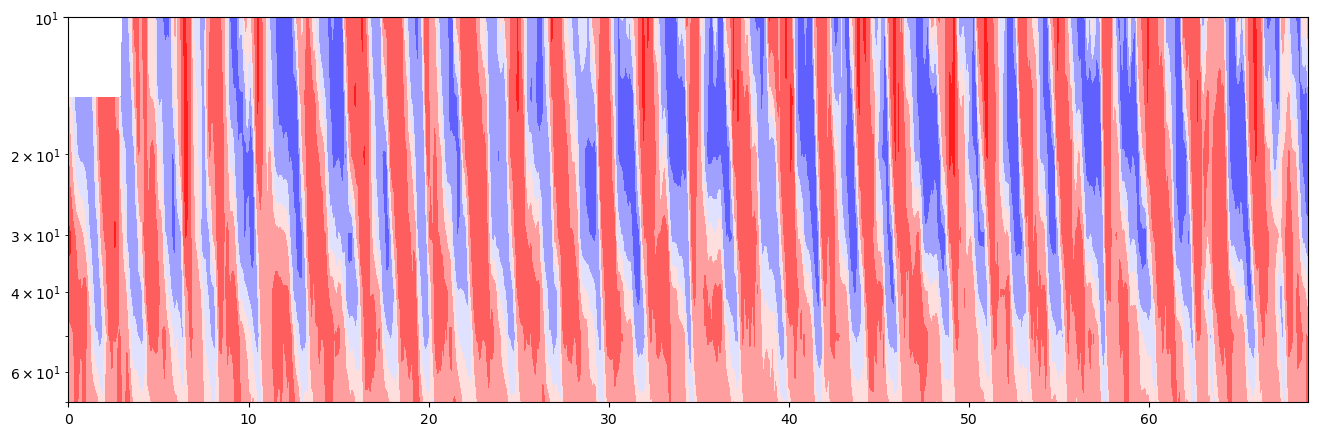

In [2]:
import matplotlib.pyplot as plt

pressures = np.array([70,50,40,30,20,15,10])

pv,tv = np.meshgrid(pressures,np.arange(data.shape[0])/12,)
fig,ax = plt.subplots(figsize=(16,5))
ax.contourf(tv,pv,data,cmap='bwr')
ax.invert_yaxis()
ax.set_yscale("log")

In [11]:
toplevel = data[:,-2]

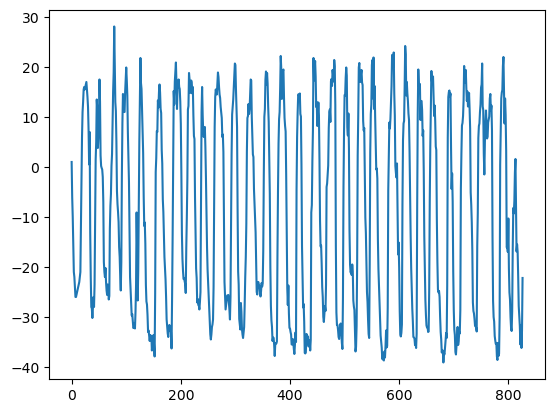

In [12]:
plt.plot(toplevel)


In [24]:
from scipy.signal import filtfilt,butter

nyqst = len(toplevel)


b,a = butter(2,0.25,btype='low',analog=False)
filttop = filtfilt(b,a,toplevel)

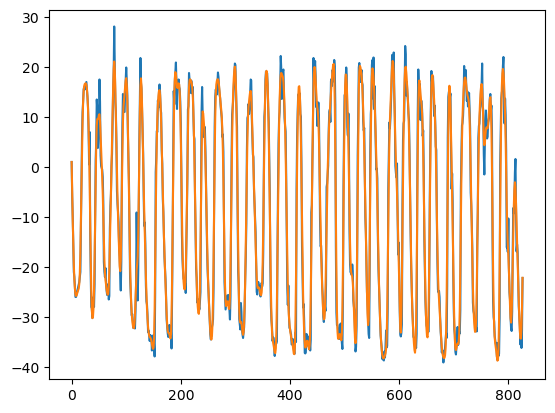

In [25]:
plt.plot(toplevel)
plt.plot(filttop)

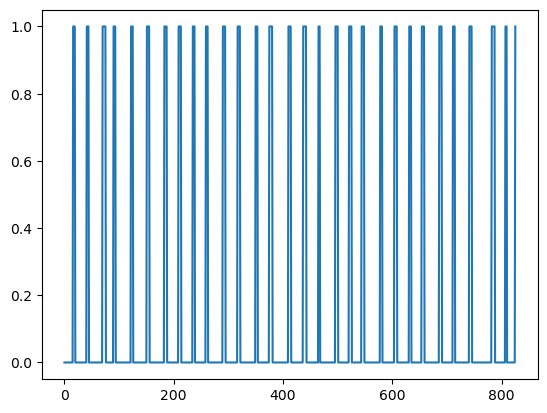

In [27]:
plt.plot(np.diff(filttop)>5)

In [65]:
def estimate_periods(signal,freq=0.25,ratecutoff=5):
    b,a = butter(2,freq,btype='low',analog=False)
    signal = filtfilt(b,a,signal)
    transitions = np.diff(signal) > ratecutoff
    periods = []
    i = 0 
    last = False
    for t in transitions:
        if t and not last: 
            periods.append(i)
            i = 0 
        else:
            i+=1
        last = t 
    return np.array(periods[1:])


In [73]:
periods_10 = estimate_periods(data[:,-1])
periods_15 = estimate_periods(data[:,-2])
periods_20 = estimate_periods(data[:,-3])
periods_30 = estimate_periods(data[:,-4])
periods_40 = estimate_periods(data[:,-5])

In [76]:
np.mean(periods_30),np.std(periods_30)

(27.5, 4.087974860678385)

In [77]:
periods_30

array([27, 20, 28, 31, 33, 23, 23, 26, 28, 27, 30, 26, 32, 29, 29, 25, 26,
       22, 34, 25, 25, 22, 29, 28, 28, 39])

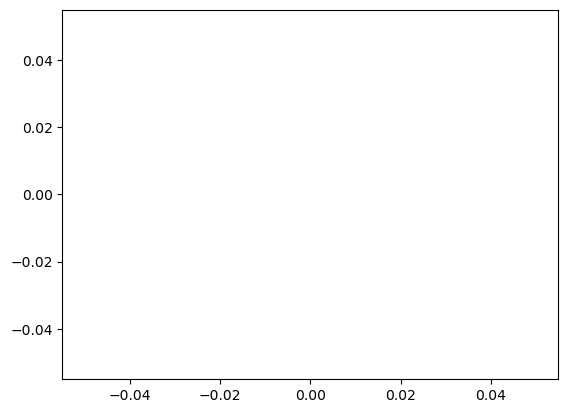

In [45]:
b,a = butter(2,0.25,btype='low',analog=False)
signal = filtfilt(b,a,data[:,-1])
plt.plot(np.diff(signal))